In [1]:
print('Module 4: ML prediction model training')

Module 4: ML prediction model training


In [2]:
import pandas as pd
import numpy as np
import argparse
import pickle
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from statistics import mean, stdev
from collections import Counter
from imblearn.metrics import classification_report_imbalanced

# Parse input

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('-a','--active', help = "Fingerprints of active compounds", required=True)
parser.add_argument('-i','--inactive', help = "Fingerprints of inactive compounds", required=True)
parser.add_argument('-m','--model', help = "Optional. Select from RF and MLP. Will report both if not specified", required=False)
parser.add_argument('-f','--file_name', help = "A name to save out files...", required=True)
args = parser.parse_args()

# Make functions

In [3]:
def read_cmpds_fp(name):
    print("Read training set fingerprint files")
    df=pd.read_csv(name)
    return df

In [4]:
def combine_sets(actives,inactives):
    frames=[actives, inactives]
    Combine = pd.concat(frames, ignore_index=True)
    Combine = np.array(Combine)
    return Combine

In [5]:
def train_test(combined_data):
    train_set, test_set = train_test_split(combined_data, test_size=0.2, random_state=17)

    X = np.array(train_set[:, 1:-1])
    y = np.array(train_set[:, -1])
    y = np.reshape(y, len(y))
    y = y.astype('int')

    X_test = np.array(test_set[:, 1:-1])
    y_test = np.array(test_set[:, -1])
    y_test = np.reshape(y_test, len(y_test))
    y_test = y_test.astype('int')
    
    print('Number of samples in each class for training %s' % Counter(y))
    print('Number of samples in each class for testing %s' % Counter(y_test))
    
    return X, y, X_test, y_test

# RF

In [6]:
def rf_grid_search(X,y):
    print('Grid search to determine RF hyperparameters')
    rus = RandomUnderSampler(random_state=17, sampling_strategy = 1)
    rfc = RandomForestClassifier(random_state=17, n_estimators=100)
    pipeline = make_pipeline(rus, rfc)
    
    kf = StratifiedKFold(n_splits=10)
    params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [17]
    }
    
    new_params = {'randomforestclassifier__' + key: params[key] for key in params}
    rf_grid_imba = GridSearchCV(pipeline, new_params, cv=kf, scoring='accuracy',
                        return_train_score=True)
    
    rf_grid_imba.fit(X, y)
    print("Best paramater grid for RF:")
    print(rf_grid_imba.best_params_)
        
    return rf_grid_imba

In [7]:
def RF_ROC_plot(rf_grid_imba, X, y, X_test, y_test):
    kf = StratifiedKFold(n_splits=10)
    rus = RandomUnderSampler(random_state=17, sampling_strategy = 1)
    rfc = RandomForestClassifier(random_state=17, n_estimators=100)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train_index, test_index in kf.split(X,y):
        X_train_1, X_test_1 = X[train_index], X[test_index]
        y_train_1, y_test_1 = y[train_index], y[test_index]
        print('Number of samples in each class %s' % Counter(y_train_1))
        X_res, y_res = rus.fit_resample(X_train_1, y_train_1)
        print('Number of samples in each class after balancing %s' % Counter(y_res))
        probas_ = rf_grid_imba.best_estimator_.predict_proba(X_test_1)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        print(roc_auc)    ###########
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='Random Forest %d (AUC = %0.3f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_RandomForest')
    plt.legend(loc="lower right")
    plt.savefig('ROC_RandomForest.png', dpi = 300) 
    plt.clf()
    print(classification_report_imbalanced(y_test, rf_grid_imba.predict(X_test)))

In [8]:
def save_out_rf(rf_grid_imba,name, X, X_test, y, y_test):
    snip_len = len('randomforestclassifier__')
    best_params = {key[snip_len:] : rf_grid_imba.best_params_[key] for key in rf_grid_imba.best_params_}

    X_all = np.concatenate((X, X_test), axis=0)
    y_all = np.concatenate((y, y_test), axis=0)
    rfc = RandomForestClassifier(**best_params).fit(X_all, y_all)
    #print(classification_report_imbalanced(y_test, rfc.predict(X_test)))
    pickle.dump(rfc, open(name + '_random_forest.sav', 'wb'))
    print("save out random forest model")

# MLP

In [9]:
def mlp_grid_search(X,y):
    print('Grid search to determine MLP hyperparameters')
    rus = RandomUnderSampler(random_state=17, sampling_strategy = 1)
    mlp = MLPClassifier(random_state=17)
    pipeline = make_pipeline(rus, mlp)
    kf = StratifiedKFold(n_splits=10)
    
    params = {
    'hidden_layer_sizes': [(50,50,50), (50,50), (50)],
    'activation': ['tanh', 'relu'],
    #'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01],
    #'learning_rate': ['constant','adaptive'],
    }
    
    new_params = {'mlpclassifier__' + key: params[key] for key in params}
    mlp_grid_imba = GridSearchCV(pipeline, param_grid=new_params, cv=kf, scoring='accuracy',refit=True,
                        return_train_score=True)
    
    mlp_grid_imba.fit(X, y)
    print("Best paramater grid for MLP:")
    print(mlp_grid_imba.best_params_)
        
    return mlp_grid_imba

In [10]:
def MLP_ROC_plot(mlp_grid_imba, X, y, X_test, y_test):
    kf = StratifiedKFold(n_splits=10)
    rus = RandomUnderSampler(random_state=17, sampling_strategy = 1)
    mlp = MLPClassifier(random_state=17)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train_index, test_index in kf.split(X,y):
        X_train_1, X_test_1 = X[train_index], X[test_index]
        y_train_1, y_test_1 = y[train_index], y[test_index]
        print('Number of samples in each class %s' % Counter(y_train_1))
        X_res, y_res = rus.fit_resample(X_train_1, y_train_1)
        print('Number of samples in each class after balancing %s' % Counter(y_res))
        probas_ = mlp_grid_imba.best_estimator_.predict_proba(X_test_1)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        print(roc_auc)    ###########
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='Multilayer perceptron %d (AUC = %0.3f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_Multilayer_perceptron')
    plt.legend(loc="lower right")
    plt.savefig('ROC_Multilayer_perceptron.png', dpi = 300) 
    plt.clf()
    print(classification_report_imbalanced(y_test, mlp_grid_imba.best_estimator_.predict(X_test)))
    

In [11]:
def save_out_mlp(mlp_grid_imba, name, X, X_test, y, y_test):
    snip_len = len('mlpclassifier__')
    best_params = {key[snip_len:] : mlp_grid_imba.best_params_[key] for key in mlp_grid_imba.best_params_}

    X_all = np.concatenate((X, X_test), axis=0)
    y_all = np.concatenate((y, y_test), axis=0)
    mlp = MLPClassifier(**best_params).fit(X_all, y_all)
    #print(classification_report_imbalanced(y_test, mlp.predict(X_test)))
    pickle.dump(mlp, open(name + '_MLP.sav', 'wb'))
    print("save out MLP model")

# Use functions

In [ ]:
actives = read_cmpds_fp(args.active)
inactives = read_cmpds_fp(args.inactive)
combined_data = combine_sets(actives,inactives)
X, y, X_test, y_test = train_test(combined_data)

In [ ]:
if args.model == 'RF':
    rf_grid_imba = rf_grid_search(X,y)
    RF_ROC_plot(rf_grid_imba, X, y, X_test, y_test)
    save_out_rf(rf_grid_imba, args.file_name, X, X_test, y, y_test)
elif args.model == 'MLP':
    mlp_grid_imba = mlp_grid_search(X,y)
    MLP_ROC_plot(mlp_grid_imba, X, y, X_test, y_test)
    save_out_mlp(mlp_grid_imba, args.file_name, X, X_test, y, y_test)
else:
    rf_grid_imba = rf_grid_search(X,y)
    RF_ROC_plot(rf_grid_imba, X, y, X_test, y_test)
    save_out_rf(rf_grid_imba, args.file_name, X, X_test, y, y_test)  
    
    mlp_grid_imba = mlp_grid_search(X,y)
    MLP_ROC_plot(mlp_grid_imba, X, y, X_test, y_test)
    save_out_mlp(mlp_grid_imba, args.file_name, X, X_test, y, y_test)    

# Example

In [13]:
actives = read_cmpds_fp('actives_CDK1_cmpds_fp.csv')
inactives = read_cmpds_fp('inactives_CDK1_cmpds_fp.csv')
combined_data = combine_sets(actives,inactives)
X, y, X_test, y_test = train_test(combined_data)

Read training set fingerprint files
Read training set fingerprint files
Number of samples in each class for training Counter({0: 2051, 1: 622})
Number of samples in each class for testing Counter({0: 515, 1: 154})


Best paramater grid for RF:
{'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 17}
Number of samples in each class Counter({0: 1845, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9868462261196368
Number of samples in each class Counter({0: 1846, 1: 559})
Number of samples in each class after balancing Counter({0: 1118, 1: 559})
0.9842818428184282
Number of samples in each class Counter({0: 1846, 1: 559})
Number of samples in each class after balancing Counter({0: 1118, 1: 559})


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9611304684475417
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9848151062155783
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9822974036191975
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9806451612903226
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9796223446105429
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9718332022029899
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.984185680566483
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9527143981117232
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.95      0.61      0.92      0.76      0.60       515
          1       0.78      0.61      0.95      0.69      0.76      0.56       154

avg / total       0.87      0.87      0.69      0.87      0.76      0.59       669

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      1.00      0.64      0.95      0.80      0.66       515
          1       0.98      0.64      1.00      0.78      0.80      0.62       154

avg / total       0.92      0.91      0.72      0.91      0.80      0.65       669

save out random forest model


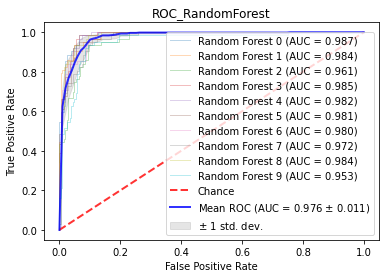

In [15]:
rf_grid_imba = rf_grid_search(X,y)
RF_ROC_plot(rf_grid_imba, X, y, X_test, y_test)
save_out_rf(rf_grid_imba,'CDK1', X, X_test, y, y_test)

/Applications/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum ite

Best paramater grid for MLP:
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (50, 50, 50)}
Number of samples in each class Counter({0: 1845, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9998434074538052
Number of samples in each class Counter({0: 1846, 1: 559})
Number of samples in each class after balancing Counter({0: 1118, 1: 559})
0.9876887340301974
Number of samples in each class Counter({0: 1846, 1: 559})
Number of samples in each class after balancing Counter({0: 1118, 1: 559})
0.9813395276809911
Number of samples in each class Counter({0: 1846, 1: 560})


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9890637293469708
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9879622344610544
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9903225806451612
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9809598741148702
Number of samples in each class Counter({0: 1846, 1: 560})


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9940204563335956
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9904012588512981
Number of samples in each class Counter({0: 1846, 1: 560})
Number of samples in each class after balancing Counter({0: 1120, 1: 560})
0.9782061369000787


/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Applications/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.87      0.73      0.89      0.80      0.64       515
          1       0.62      0.73      0.87      0.67      0.80      0.63       154

avg / total       0.85      0.84      0.76      0.84      0.80      0.64       669

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.99      1.00      0.99      0.99       515
          1       0.97      0.99      0.99      0.98      0.99      0.99       154

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       669

save out MLP model


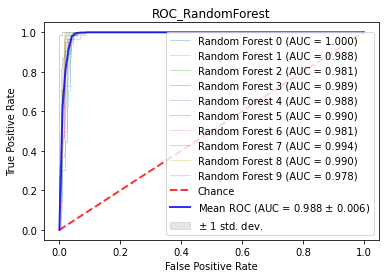

In [16]:
mlp_grid_imba = mlp_grid_search(X,y)
MLP_ROC_plot(mlp_grid_imba, X, y, X_test, y_test)
save_out_mlp(mlp_grid_imba, 'CDK1', X, X_test, y, y_test)